### Importo librerie

In [50]:
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import time
import progressbar

from collections import defaultdict
from scipy.stats.stats import pearsonr

import operator, statistics
from statistics import mean
import matplotlib.patches as mpatches
from msda.msda import *
from msda.anamoly import *
from keijzer import *

%matplotlib inline

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"} # Make sure the axis background of plots is white, this is usefull for the black theme in JupyterLab
sns.set()

### Leggo dataset normalizzato, imposto il timestamp come indice

In [51]:
df = pd.read_pickle("files/recofill_tb_timeseriesdata_1st_clean.pkl")

In [52]:
df['utctimestamp'] = df['utctimestamp'].astype('datetime64[s]')

In [53]:
df.set_index('utctimestamp', inplace=True)

### Gestisco i missing values e salvo il nuovo dataset

In [8]:
print("Missing information for whole dataset")
print("Missing by row", df.apply(Preprocessing.missing, axis=0)) # col
print("Missing by col", df.apply(Preprocessing.missing, axis=1)) # row

Missing information for whole dataset
Missing by row utctimestamp                   0
A-MeltPress-Die                0
A-MonomerFlap                  0
A-QuenchingCab-Press           0
A-CoolingAir-FlowRate          0
A2-CoolingAir-FlowRate         0
A-ProcessAir-Ratio             0
A-Extruder-Speed               0
A-SpinPump-Speed               0
A-SuctionAirFan-Speed          0
A2-SuctionAirFan-Speed         0
A1-PA-CoolingAir-Temp          0
A2-PA-CoolingAir-Temp          0
B-MeltPress-Die                0
B-QuenchingCab-Press           0
B-SpinPump-Speed               0
B2-SuctionAirFan-Speed         0
B1-PA-CoolingAir-Temp          0
B2-PA-CoolingAir-Temp          0
C-ProcessAir-Temp              0
C-ProcessAir-Volume            0
C-Extruder-Speed               0
C-SpinPump-Speed               0
C-SuctionAirFan-Speed          0
D-ProcessAir-Temp              0
D-ProcessAir-Volume            0
D-Extruder-Speed               0
D-SpinPump-Speed               0
D-SuctionAirFan-Speed  

In [54]:
df = ExploratoryDataAnalysis.impute(df=df, modes=2)
#2=mediana

In [9]:
df.to_pickle("files/recofill_imputation.pkl")

In [9]:
df=pd.read_pickle("files/recofill_imputation.pkl")

### Calcolo la correlazione tra le variabili (Pearson Correlation)

In [55]:
corr=df.corr() #.style.background_gradient(cmap='coolwarm')

In [56]:
corr.style.background_gradient(cmap='coolwarm')

,A-MeltPress-Die,A-MonomerFlap,A-QuenchingCab-Press,A-CoolingAir-FlowRate,A2-CoolingAir-FlowRate,A-ProcessAir-Ratio,A-Extruder-Speed,A-SpinPump-Speed,A-SuctionAirFan-Speed,A2-SuctionAirFan-Speed,A1-PA-CoolingAir-Temp,A2-PA-CoolingAir-Temp,B-MeltPress-Die,B-QuenchingCab-Press,B-SpinPump-Speed,B2-SuctionAirFan-Speed,B1-PA-CoolingAir-Temp,B2-PA-CoolingAir-Temp,C-ProcessAir-Temp,C-ProcessAir-Volume,C-Extruder-Speed,C-SpinPump-Speed,C-SuctionAirFan-Speed,D-ProcessAir-Temp,D-ProcessAir-Volume,D-Extruder-Speed,D-SpinPump-Speed,D-SuctionAirFan-Speed,E-MonomerFlap,E-QuenchingCab-Press,E-CoolingAir-FlowRate,E-MeltPress-Die,E2-CoolingAir-FlowRate,E-ProcessAir-Ratio,E-Extruder-Speed,E-SpinPump-Speed,E-SuctionAirFan-Speed,E2-SuctionAirFan-Speed,E1-PA-CoolingAir-Temp,E2-PA-CoolingAir-Temp,L-Cal-PvHeatStr1TempPr,L-Cal-PvHeatHSRTempPr,L-Cal-PvDrHSRV,L-Cal-SRoll-Draft
A-MeltPress-Die,1.000000,0.993782,0.993795,0.981834,0.991459,0.958671,0.997436,0.998616,0.945005,0.966274,-0.225142,-0.326845,-0.563517,0.663898,-0.005805,0.136486,0.935444,0.933566,0.822929,0.861835,0.784561,0.834808,0.799153,0.821577,0.860527,0.777597,0.835264,0.787879,0.990776,0.993468,0.993213,0.987147,0.992587,0.958943,0.992437,0.993068,0.948857,0.970910,-0.324527,-0.180886,0.394002,0.433397,0.289619,0.189703
A-MonomerFlap,0.993782,1.000000,0.998145,0.983957,0.994801,0.956814,0.996961,0.996704,0.945652,0.969064,-0.222455,-0.324506,-0.577688,0.680066,-0.005813,0.146058,0.941536,0.940304,0.823043,0.869290,0.794665,0.839555,0.800069,0.821777,0.868042,0.787566,0.839976,0.788089,0.985857,0.999447,0.997443,0.989189,0.995429,0.956471,0.992483,0.992134,0.949428,0.973498,-0.320922,-0.176623,0.394683,0.429320,0.280828,0.199225
A-QuenchingCab-Press,0.993795,0.998145,1.000000,0.984555,0.996325,0.957201,0.997285,0.997246,0.944545,0.968017,-0.234394,-0.333543,-0.572353,0.675464,-0.005854,0.133157,0.942902,0.941986,0.828190,0.875269,0.799724,0.845895,0.804806,0.827026,0.873985,0.792590,0.846342,0.792737,0.985459,0.997734,0.999462,0.989756,0.996978,0.956085,0.992720,0.992585,0.947657,0.970887,-0.332538,-0.188782,0.403127,0.440803,0.292808,0.200607
A-CoolingAir-FlowRate,0.981834,0.983957,0.984555,1.000000,0.993729,0.983477,0.983704,0.984143,0.933509,0.951068,-0.233189,-0.333154,-0.545125,0.671642,-0.005740,0.120141,0.922858,0.922837,0.812297,0.856761,0.782483,0.828290,0.788473,0.811274,0.855443,0.775842,0.828759,0.776558,0.973264,0.983559,0.983783,0.976440,0.982296,0.945653,0.979228,0.979275,0.936479,0.954471,-0.339849,-0.196330,0.403634,0.443270,0.297631,0.196721
A2-CoolingAir-FlowRate,0.991459,0.994801,0.996325,0.993729,1.000000,0.972792,0.994450,0.994548,0.942397,0.963549,-0.234922,-0.332981,-0.561519,0.676915,-0.005828,0.127002,0.937450,0.937029,0.823359,0.869510,0.794021,0.840868,0.799585,0.822245,0.868206,0.786956,0.841328,0.787640,0.982946,0.994407,0.995692,0.986863,0.993673,0.954079,0.989810,0.989726,0.945520,0.966517,-0.336301,-0.191962,0.403890,0.443211,0.297258,0.198117
A-ProcessAir-Ratio,0.958671,0.956814,0.957201,0.983477,0.972792,1.000000,0.959103,0.959793,0.913080,0.926655,-0.225132,-0.320241,-0.526225,0.660659,-0.005554,0.114501,0.898672,0.898754,0.792385,0.831420,0.760126,0.804014,0.769300,0.791398,0.830103,0.753995,0.804485,0.757854,0.953543,0.956376,0.957222,0.954823,0.957633,0.930828,0.957659,0.957763,0.915912,0.930567,-0.332215,-0.194836,0.394385,0.433361,0.289827,0.190349
A-Extruder-Speed,0.997436,0.996961,0.997285,0.983704,0.994450,0.959103,1.000000,0.999504,0.948446,0.970556,-0.219066,-0.321969,-0.576191,0.684201,-0.005672,0.145973,0.943551,0.942345,0.828337,0.870309,0.796692,0.841016,0.805766,0.827043,0.869054,0.789794,0.841450,0.793980,0.989109,0.996634,0.996861,0.990219,0.995595,0.959736,0.995193,0.994650,0.952029,0.974956,-0.319058,-0.177773,0.393962,0.429401,0.279337,0.198549
A-SpinPump-Speed,0.998616,0.996704,0.997246,0.984143,0.994548,0.959793,0.999504,1.000000,0.946732,0.968424,-0.227258,-0.329937,-0.570278,0.676859,-0.005807,0.137221,0.941391,0.940211,0.82704

In [57]:
mask_ut=np.triu(np.ones(corr.shape)).astype(bool)

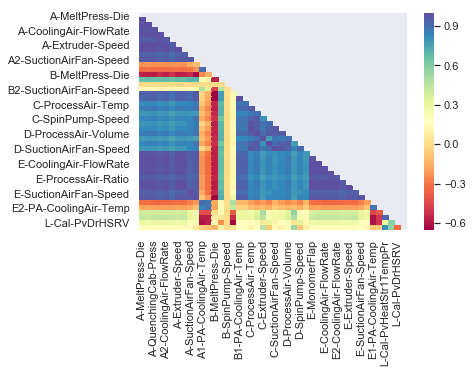

In [58]:
hmap=sns.heatmap(corr, mask=mask_ut, cmap="Spectral")
hmap.figure.savefig("Correlation_Heatmap_Lower_Triangle_with_Seaborn_using_mask.png",
                    format='png',
                    dpi=250)

In [59]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

In [60]:
pd.set_option('display.max_rows', 160)
print("Top Absolute Correlations")
print(get_top_abs_correlations(df, 150))

Top Absolute Correlations
C-SpinPump-Speed        D-SpinPump-Speed          0.999883
C-ProcessAir-Temp       D-ProcessAir-Temp         0.999538
A-Extruder-Speed        A-SpinPump-Speed          0.999504
A-QuenchingCab-Press    E-CoolingAir-FlowRate     0.999462
A-MonomerFlap           E-QuenchingCab-Press      0.999447
E-Extruder-Speed        E-SpinPump-Speed          0.999354
C-ProcessAir-Volume     D-ProcessAir-Volume       0.998984
B1-PA-CoolingAir-Temp   B2-PA-CoolingAir-Temp     0.998618
A-MeltPress-Die         A-SpinPump-Speed          0.998616
A-MonomerFlap           A-QuenchingCab-Press      0.998145
E-CoolingAir-FlowRate   E2-CoolingAir-FlowRate    0.998054
A-SuctionAirFan-Speed   E-SuctionAirFan-Speed     0.997929
A-QuenchingCab-Press    E-QuenchingCab-Press      0.997734
E-MonomerFlap           E-SpinPump-Speed          0.997514
A-MonomerFlap           E-CoolingAir-FlowRate     0.997443
A-MeltPress-Die         A-Extruder-Speed          0.997436
A-QuenchingCab-Press    A-Extr

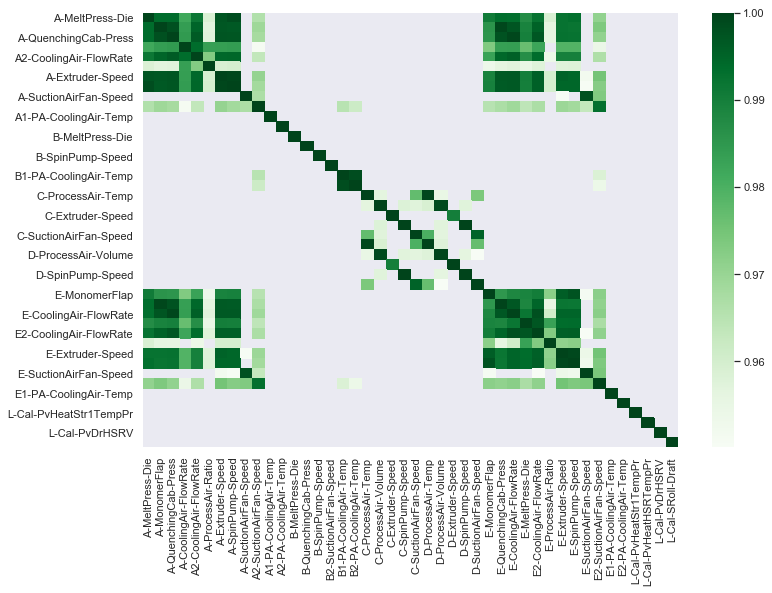

In [61]:
kot = corr[corr>=.95]
plt.figure(figsize=(12,8))
sns.heatmap(kot, cmap="Greens")

In [62]:
#plt.figure(figsize=(15,8))
#sns.lineplot(x=df.index, y='A-MonomerFlap', data=df)

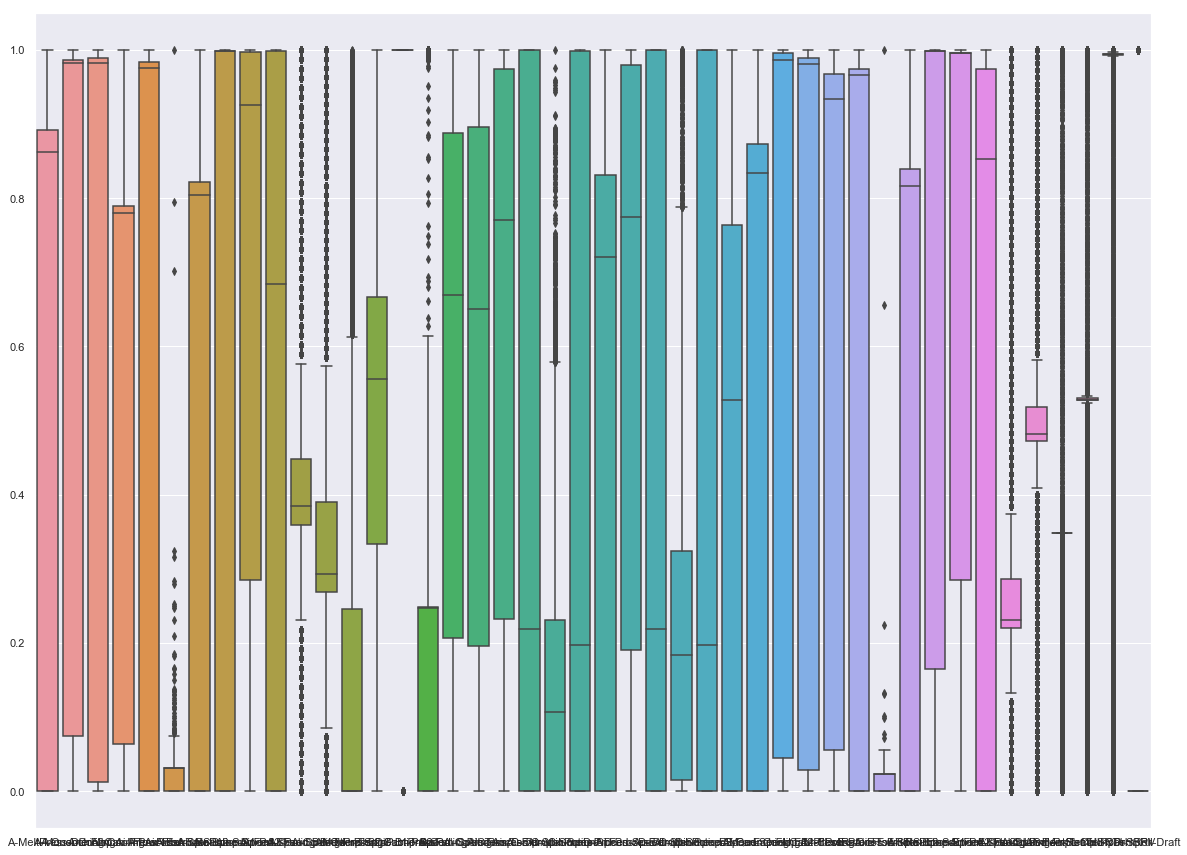

In [63]:
plt.figure(figsize=(20,15))
sns.boxplot(data=df)

In [10]:
df=pd.read_pickle("files/recofill_imputation.pkl")

### Preparo il dataset per la PiecewiseAggregateApproximation
Attenzione: si perde il timestamp

In [64]:
df = df.reset_index(drop=True)

In [65]:
from tslearn.piecewise import PiecewiseAggregateApproximation

In [66]:
df_t = df.T

In [67]:
# PAA transform (and inverse transform) of the data
n_paa_segments = 300
paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)
ts_paa = paa.fit_transform(df_t)

C:\Users\gabri\Anaconda3\lib\site-packages\tslearn\utils\utils.py:89: UserWarning:

2-Dimensional data passed. Assuming these are 44 1-dimensional timeseries



In [68]:
array_to_df = pd.DataFrame(ts_paa[:,:,0])

In [69]:
array_to_df_t=array_to_df.T

In [70]:
array_to_df_t.columns=df.columns

In [71]:
array_to_df_t

,A-MeltPress-Die,A-MonomerFlap,A-QuenchingCab-Press,A-CoolingAir-FlowRate,A2-CoolingAir-FlowRate,A-ProcessAir-Ratio,A-Extruder-Speed,A-SpinPump-Speed,A-SuctionAirFan-Speed,A2-SuctionAirFan-Speed,...,E-Extruder-Speed,E-SpinPump-Speed,E-SuctionAirFan-Speed,E2-SuctionAirFan-Speed,E1-PA-CoolingAir-Temp,E2-PA-CoolingAir-Temp,L-Cal-PvHeatStr1TempPr,L-Cal-PvHeatHSRTempPr,L-Cal-PvDrHSRV,L-Cal-SRoll-Draft
0,0.000747,0.074890,0.010371,0.063891,0.000000,0.000000,0.000000,0.000245,0.000000,0.000000,...,0.000000,0.165190,0.000000,0.000000,0.405322,0.625772,0.348591,0.527156,0.994060,0.0
1,0.000747,0.074890,0.010922,0.063891,0.000000,0.000000,0.000000,0.000245,0.000000,0.000000,...,0.000000,0.165190,0.000000,0.000000,0.423263,0.649740,0.348591,0.527156,0.994060,0.0
2,0.000747,0.074890,0.011067,0.063891,0.000000,0.000000,0.000000,0.000245,0.000000,0.000000,...,0.000000,0.165190,0.000000,0.000000,0.436669,0.663619,0.348591,0.527156,0.994060,0.0
3,0.000746,0.074890,0.010298,0.063891,0.000000,0.000000,0.000000,0.000245,0.000000,0.000000,...,0.000000,0.165190,0.000000,0.000000,0.430571,0.664469,0.348591,0.527156,0.994060,0.0
4,0.000747,0.074890,0.010655,0.063891,0.000000,0.000000,0.000000,0.000245,0.000000,0.000000,...,0.000000,0.165190,0.000000,0.000000,0.442674,0.669715,0.348591,0.527156,0.994060,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.873725,0.986884,0.988960,0.788145,0.982284,0.031044,0.821633,0.998935,0.926058,0.683150,...,0.845630,0.999127,0.996395,0.852022,0.219159,0.480660,0.982250,0.974567,0.334895,1.0
296,0.872410,0.986800,0.988964,0.786525,0.981926,0.031044,0.823511,0.998938,0.926062,0.683156,...,0.847827,0.999138,0.996397,0.852018,0.224186,0.479393,0.982449,0.974805,0.334923,1.0
297,0.870911,0.986930,0.988971,0.784909,0.981014,0.031044,0.825243,0.998937,0.926066,0.683148,...,0.849740,0.999137,0.996392,0.852026,0.217031,0.482568,0.982481,0.974012,0.334913,1.0
298,0.870176,0.986801,0.988944,0.783029,0.981005,0.031044,0.826817,0.998939,0.926056,0.683151,...,0.851144,0.999142,0.996393,0.852011,0.222219,0.483451,0.982575,0.974168,0.334904,1.0


In [72]:
array_to_df_t.to_pickle("files/recofill_paa.pkl")

### Rivaluto le correlazioni per capire se rimangono pressoché inalterate dopo l'approssimazione

In [73]:
corr_sampled=array_to_df_t.corr() #.style.background_gradient(cmap='coolwarm')

In [74]:
mask_ut=np.triu(np.ones(corr_sampled.shape)).astype(bool)

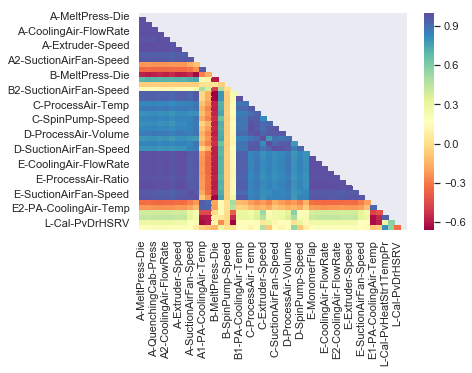

In [75]:
hmap=sns.heatmap(corr_sampled, mask=mask_ut, cmap="Spectral")
hmap.figure.savefig("Correlation_Heatmap_Lower_Triangle_with_Seaborn_using_mask_sampled.png",
                    format='png',
                    dpi=250)

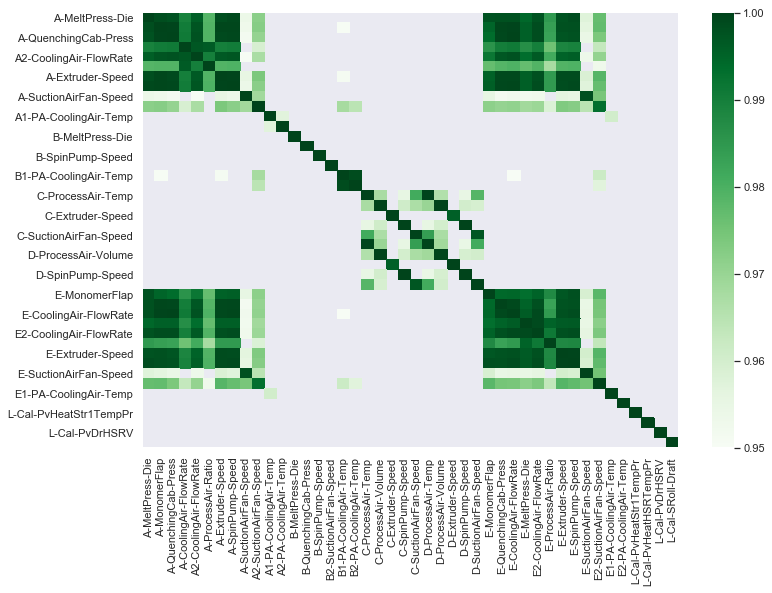

In [76]:
kot_sampled = corr_sampled[corr_sampled>=.95]
plt.figure(figsize=(12,8))
sns.heatmap(kot_sampled, cmap="Greens")

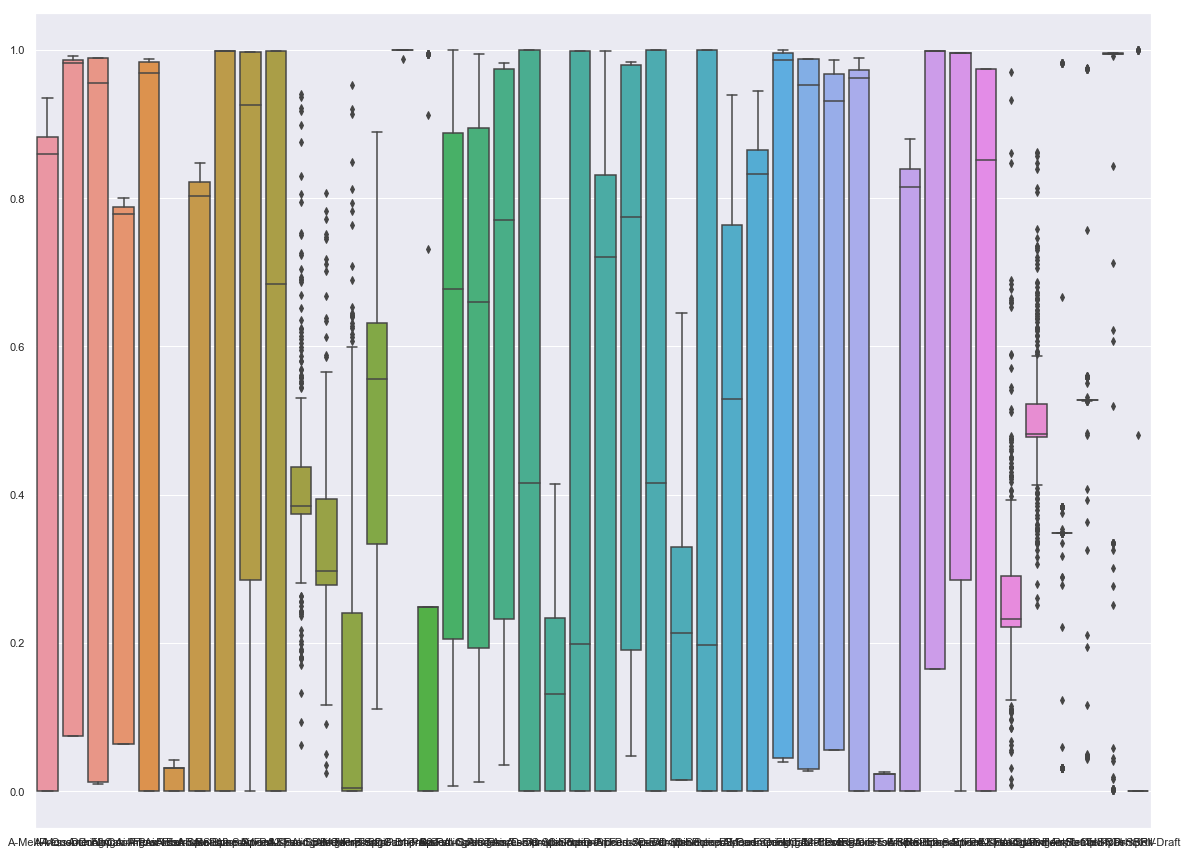

In [79]:
plt.figure(figsize=(20,15))
sns.boxplot(data=array_to_df_t)

### Plotto tutte le time series per una visione d'insieme

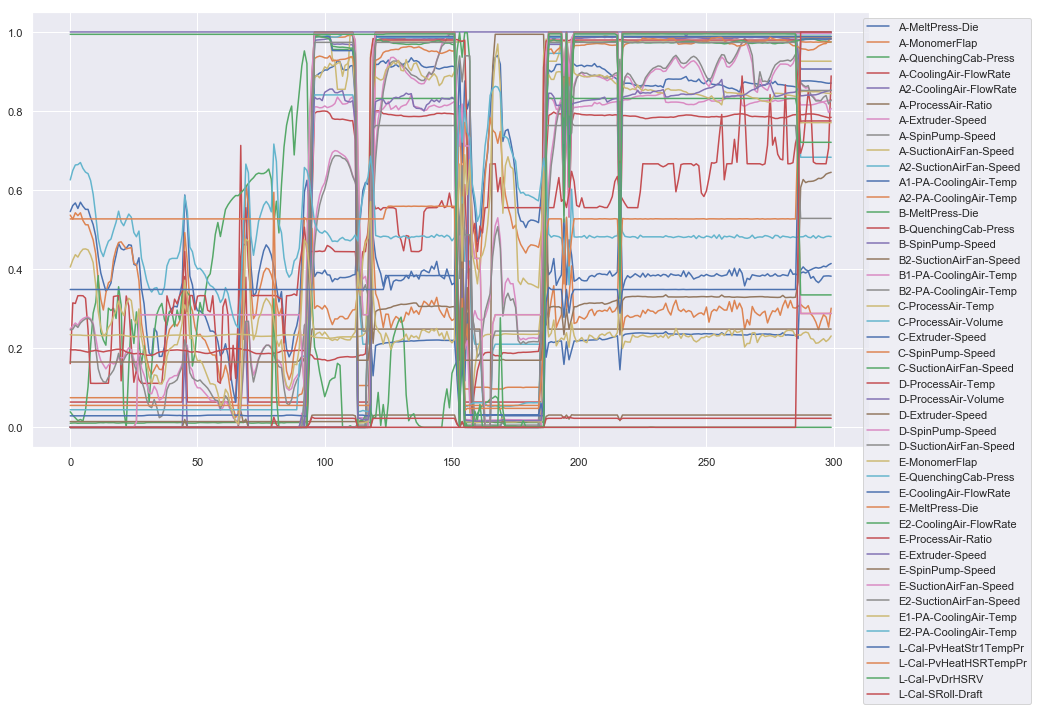

In [77]:
array_to_df_t.plot(figsize=(15,8)).legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
